# Example 2. WSBMs on simulated data

Here we demonstrate how VIRGMo can be used to fit different weighted SBMs to the synthetic data produced from the same model. This example follows Example 1 but with addition of edges' weights.

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import sys
sys.path.append('../src/')
from vi_sbm import *
from graph_models import WSBM, WDCSBM, EdgesDataset
torch.manual_seed(1553)

## WSBM

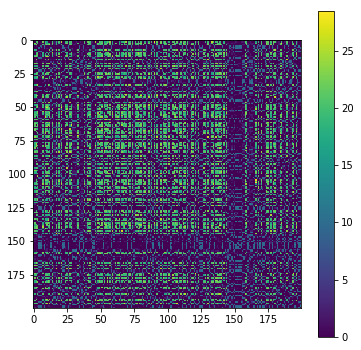

In [2]:
N = 200                              # Number of nodes
num_classes = 3                      # Number of classes
p = torch.tensor([0.2, 0.3, 0.5])    # Probability of each class
B = torch.tensor([                   # Connection probability between classes
        [0.8, 0.1, 0.3],
        [0.1, 0.9, 0.1],
        [0.5, 0.1, 0.8]])
w_mu = torch.tensor([                # Weight distributions means
            [10., 5., 2.],
            [5., 10., 2.],
            [2., 2., 20.]]).log()
w_tau = torch.ones([3,3])*100        # Weight distributions precision
wsbm = WSBM(p, B, w_mu, w_tau)
z, A = wsbm.generate(N)              # Generate the class assignments z and the adjacency matrix A
wsbm.show(sorted=False)    # Show A (white is the zero-edges)

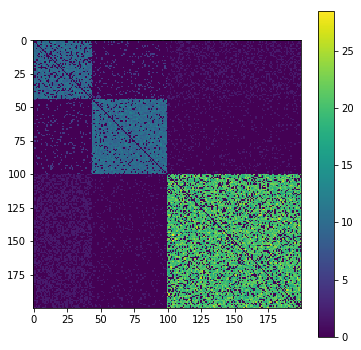

In [3]:
wsbm.show(sorted=True)    # Show A sorted by class (white is the zero-edges)

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 100031.48 | Epoch time 1.88
Epoch 2 | LR: 0.10 | Total loss: 75581.41 | Epoch time 1.83
Epoch 3 | LR: 0.10 | Total loss: 59350.63 | Epoch time 1.30
Epoch 4 | LR: 0.10 | Total loss: 52985.32 | Epoch time 1.47
Epoch 5 | LR: 0.10 | Total loss: 48908.96 | Epoch time 1.68
Epoch 6 | LR: 0.10 | Total loss: 44402.31 | Epoch time 1.66
Epoch 7 | LR: 0.10 | Total loss: 42988.08 | Epoch time 1.08
Epoch 8 | LR: 0.10 | Total loss: 42573.48 | Epoch time 1.83
Epoch 9 | LR: 0.10 | Total loss: 42372.07 | Epoch time 1.78
Epoch 10 | LR: 0.10 | Total loss: 42302.57 | Epoch time 1.80
Epoch 11 | LR: 0.05 | Total loss: 42260.77 | Epoch time 1.24
Epoch 12 | LR: 0.05 | Total loss: 42197.88 | Epoch time 1.08
Epoch 13 | LR: 0.05 | Total loss: 42211.45 | Epoch time 1.09
Epoch 14 | LR: 0.05 | Total loss: 42203.86 | Epoch time 1.40
Epoch 15 | LR: 0.05 | Total loss: 42164.31 | Epoch time 1.38
Epoch 16 | LR: 0.05 | Total loss: 42171.16 | Epoch time 1.36
E

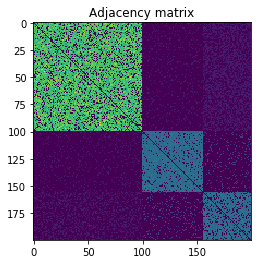

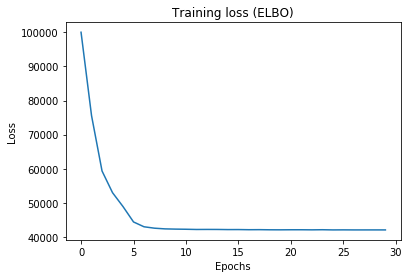

Latent class accuracy: 1.0
Classes probability [0.51 0.27 0.22]
Edges probability:
 [[0.81 0.1  0.49]
 [0.1  0.88 0.1 ]
 [0.31 0.11 0.8 ]]
Expected mean weight:
 [[3.02 0.68 0.68]
 [0.71 2.29 1.59]
 [0.68 1.61 2.29]]
Expected precision weight:
 [[94.81 67.81 81.18]
 [65.66 98.15 55.15]
 [85.58 47.56 76.62]]


In [4]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_WSBM(num_nodes=N, num_classes=num_classes)
vi.train(dataloader, epochs=10, lrs=[0.1, 0.05, 0.01])
vi.summary(A, z)

In [5]:
q_eta, q_theta, q_B, q_w_mu, q_w_tau = vi.constrained_params()    # Get the parameters

In [6]:
permutation = [2,1,0]  # You may have to change the permutation
q_theta_perm = q_theta.detach()[permutation]
num_samples = 2000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

In [7]:
import seaborn as sns
sns.set()

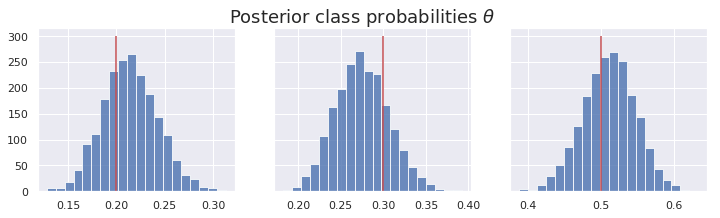

In [8]:
fig, axs = plt.subplots(1, num_classes, figsize=(12, 3), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
plt.show()

In [9]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

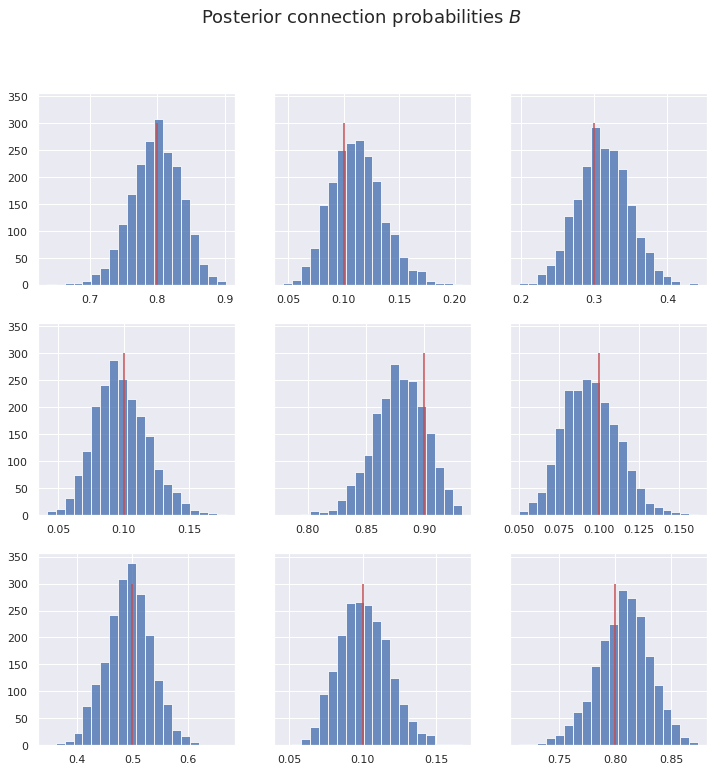

In [10]:
fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
plt.show()

Now, let us compare sampled weights from the true and approximating distributions.

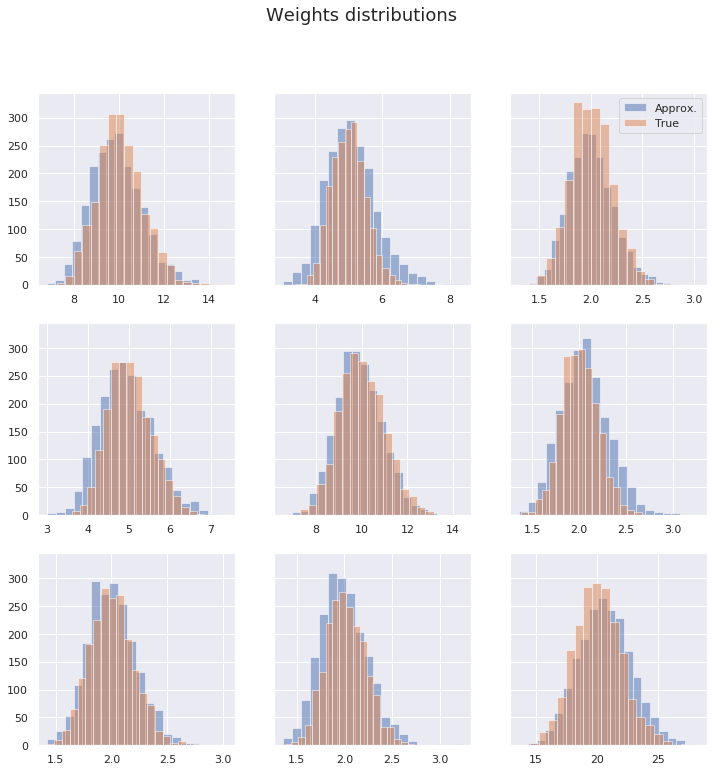

In [11]:
_,_,_, q_w_mu_mean, q_w_tau_mean = vi.qmean()    # Get the parameter means

from torch.distributions.log_normal import LogNormal
q_w_mu_mean_perm = q_w_mu_mean.detach()[permutation,:][:,permutation]
q_w_tau_mean_perm = q_w_tau_mean.detach()[permutation,:][:,permutation]
q_w_samples = LogNormal(q_w_mu_mean_perm, 1/q_w_tau_mean_perm.sqrt()).sample([num_samples])
p_w_samples = LogNormal(w_mu, 1/w_tau.sqrt()).sample([num_samples])
fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)

bins, alpha = 20, 0.5
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(q_w_samples[:,i, j], bins=bins, alpha=alpha, label='Approx.') 
        axs[i,j].hist(p_w_samples[:,i, j], bins=bins, alpha=alpha, label='True') 
axs[0,2].legend()
fig.suptitle(r'Weights distributions', fontsize=18)
plt.show()

--------------------

## WDCSBM

In [12]:
sns.reset_orig()

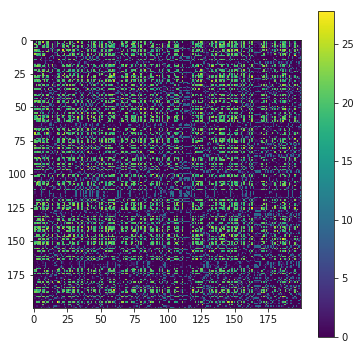

In [13]:
N = 200                              # Number of nodes
num_classes = 3                      # Number of classes
p = torch.tensor([0.2, 0.3, 0.5])    # Probability of each class
B = torch.tensor([                   # Connection probability between classes
        [0.8, 0.1, 0.3],
        [0.1, 0.9, 0.1],
        [0.5, 0.1, 0.8]])
delta = torch.tensor(
    [[2.,2.], [3.,3.], [5.,5.]])     # Parameters of degree distributions
w_mu = torch.tensor([                # Weight distributions means
            [10., 5., 2.],
            [5., 10., 2.],
            [2., 2., 20.]]).log()
w_tau = torch.ones([3,3])*100        # Weight distributions precision
wdcsbm = WDCSBM(p, B, delta, w_mu, w_tau)
z, A = wdcsbm.generate(N)            # Generate the class assignments z and the adjacency matrix A
wdcsbm.show(sorted=False)            # Show A

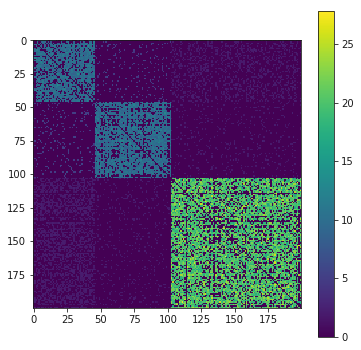

In [14]:
wdcsbm.show(sorted=True)    # Show A sorted by class

In [16]:
# Degree initialization
delta_init = torch.ones([N,2])
delta_mu = A.sum(dim=1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [17]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_WDCSBM(num_nodes=N, num_classes=num_classes,
              init_values={'etas':None, 
                              'thetas':None, 
                              'Bs':None, 
                              'deltas':delta_init,
                              'mus':None,
                              'taus':None})
vi.multi_train(dataloader, epochs=15, lrs=[0.1, 0.05, 0.01], trials=10)

>>>>>>> Training iteration #1 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 88352.52 | Epoch time 2.66
Epoch 2 | LR: 0.10 | Total loss: 65701.81 | Epoch time 2.88
Epoch 3 | LR: 0.10 | Total loss: 53083.66 | Epoch time 3.01
Epoch 4 | LR: 0.10 | Total loss: 48690.40 | Epoch time 2.78
Epoch 5 | LR: 0.10 | Total loss: 47231.04 | Epoch time 2.70
Epoch 6 | LR: 0.10 | Total loss: 46735.11 | Epoch time 2.60
Epoch 7 | LR: 0.10 | Total loss: 46513.62 | Epoch time 2.47
Epoch 8 | LR: 0.10 | Total loss: 46423.88 | Epoch time 3.07
Epoch 9 | LR: 0.10 | Total loss: 46342.90 | Epoch time 3.21
Epoch 10 | LR: 0.10 | Total loss: 45926.65 | Epoch time 1.86
Epoch 11 | LR: 0.10 | Total loss: 45899.68 | Epoch time 2.80
Epoch 12 | LR: 0.10 | Total loss: 45926.38 | Epoch time 3.05
Epoch 13 | LR: 0.10 | Total loss: 45862.76 | Epoch time 1.98
Epoch 14 | LR: 0.10 | Total loss: 45866.04 | Epoch time 1.87
Epoch 15 | LR: 0.10 | Total loss: 45857.13 | Epoch time 1.83
Epoch 16 | LR: 0.05 | Total los

Epoch 42 | LR: 0.01 | Total loss: 37877.68 | Epoch time 1.77
Epoch 43 | LR: 0.01 | Total loss: 37899.89 | Epoch time 1.75
Epoch 44 | LR: 0.01 | Total loss: 37910.62 | Epoch time 1.73
Epoch 45 | LR: 0.01 | Total loss: 37910.25 | Epoch time 1.76
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #4 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 89357.78 | Epoch time 2.01
Epoch 2 | LR: 0.10 | Total loss: 81690.14 | Epoch time 3.38
Epoch 3 | LR: 0.10 | Total loss: 80184.28 | Epoch time 2.95
Epoch 4 | LR: 0.10 | Total loss: 75204.45 | Epoch time 2.92
Epoch 5 | LR: 0.10 | Total loss: 69399.89 | Epoch time 2.15
Epoch 6 | LR: 0.10 | Total loss: 68208.10 | Epoch time 1.73
Epoch 7 | LR: 0.10 | Total loss: 67860.54 | Epoch time 1.71
Epoch 8 | LR: 0.10 | Total loss: 67652.41 | Epoch time 1.72
Epoch 9 | LR: 0.10 | Total loss: 66576.77 | Epoch time 1.72
Epoch 10 | LR: 0.10 | Total loss: 54574.99 | Epoch time 1.71
Epoch 11 | LR: 0.10 | Total loss: 44097.86 | Epoch time 

Epoch 37 | LR: 0.01 | Total loss: 37949.67 | Epoch time 1.81
Epoch 38 | LR: 0.01 | Total loss: 37868.19 | Epoch time 1.77
Epoch 39 | LR: 0.01 | Total loss: 37917.85 | Epoch time 1.78
Epoch 40 | LR: 0.01 | Total loss: 37907.84 | Epoch time 1.74
Epoch 41 | LR: 0.01 | Total loss: 37896.34 | Epoch time 1.76
Epoch 42 | LR: 0.01 | Total loss: 37903.17 | Epoch time 1.76
Epoch 43 | LR: 0.01 | Total loss: 37904.32 | Epoch time 1.93
Epoch 44 | LR: 0.01 | Total loss: 37896.80 | Epoch time 1.77
Epoch 45 | LR: 0.01 | Total loss: 37903.08 | Epoch time 2.35
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #7 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 89157.52 | Epoch time 1.76
Epoch 2 | LR: 0.10 | Total loss: 81604.22 | Epoch time 2.10
Epoch 3 | LR: 0.10 | Total loss: 80296.55 | Epoch time 2.93
Epoch 4 | LR: 0.10 | Total loss: 79836.55 | Epoch time 2.69
Epoch 5 | LR: 0.10 | Total loss: 79605.32 | Epoch time 1.78
Epoch 6 | LR: 0.10 | Total loss: 79451.73 | Epoch ti

Epoch 32 | LR: 0.01 | Total loss: 45015.55 | Epoch time 2.05
Epoch 33 | LR: 0.01 | Total loss: 44992.52 | Epoch time 2.49
Epoch 34 | LR: 0.01 | Total loss: 44991.38 | Epoch time 1.92
Epoch 35 | LR: 0.01 | Total loss: 44983.01 | Epoch time 3.09
Epoch 36 | LR: 0.01 | Total loss: 44985.83 | Epoch time 3.18
Epoch 37 | LR: 0.01 | Total loss: 44982.39 | Epoch time 3.39
Epoch 38 | LR: 0.01 | Total loss: 45007.39 | Epoch time 3.08
Epoch 39 | LR: 0.01 | Total loss: 44974.32 | Epoch time 2.78
Epoch 40 | LR: 0.01 | Total loss: 44993.72 | Epoch time 2.74
Epoch 41 | LR: 0.01 | Total loss: 44978.31 | Epoch time 3.00
Epoch 42 | LR: 0.01 | Total loss: 44984.49 | Epoch time 2.95
Epoch 43 | LR: 0.01 | Total loss: 44945.05 | Epoch time 2.97
Epoch 44 | LR: 0.01 | Total loss: 44989.51 | Epoch time 3.08
Epoch 45 | LR: 0.01 | Total loss: 45003.71 | Epoch time 3.98
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #10 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 91747.95 | Ep

In [18]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B, q_delta , q_w_mu, q_w_tau = vi.constrained_params()

vi.multi_results[1][best_trial]                     # Chose the correct permutation

tensor([0.2721, 0.2333, 0.4946])

In [19]:
permutation = [1,0,2]  # You may have to change the permutation
q_theta_perm = q_theta.detach()[permutation]
num_samples = 2000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

In [20]:
import seaborn as sns
sns.set()

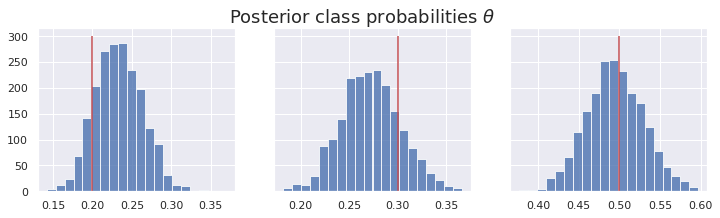

In [21]:
fig, axs = plt.subplots(1, num_classes, figsize=(12, 3), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
plt.show()

In [22]:
print('Latent class accuracy:', vi.class_accuracy(z).numpy().item())

Latent class accuracy: 1.0


In [23]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

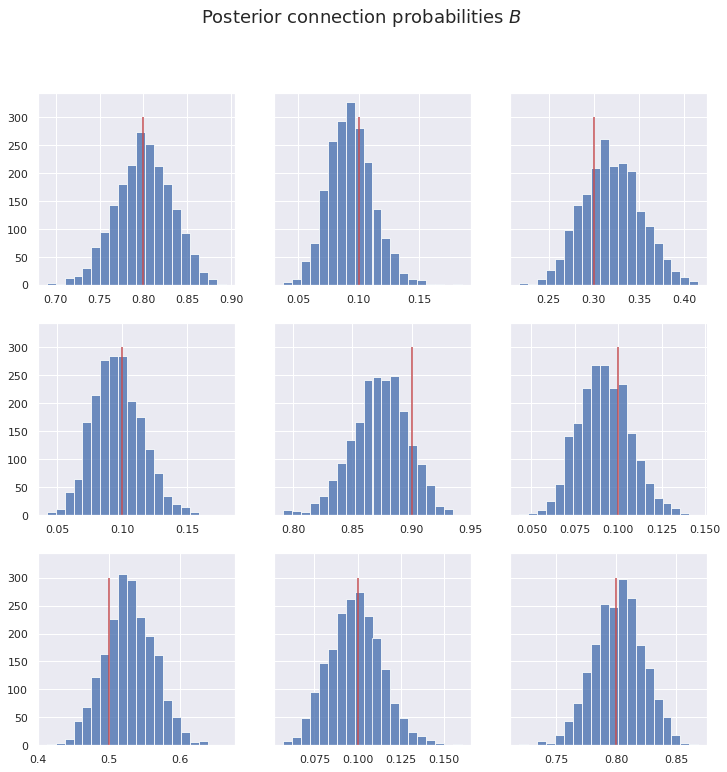

In [24]:
fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
plt.show()

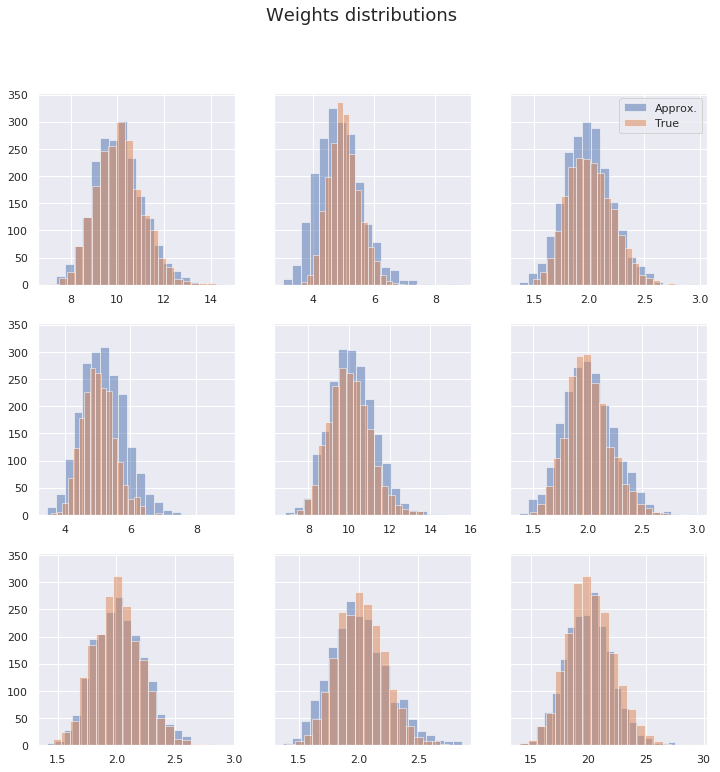

In [25]:
_,_,_,_, q_w_mu_mean, q_w_tau_mean = vi.qmean()    # Get the parameter means

from torch.distributions.log_normal import LogNormal
q_w_mu_mean_perm = q_w_mu_mean.detach()[permutation,:][:,permutation]
q_w_tau_mean_perm = q_w_tau_mean.detach()[permutation,:][:,permutation]
q_w_samples = LogNormal(q_w_mu_mean_perm, 1/q_w_tau_mean_perm.sqrt()).sample([num_samples])
p_w_samples = LogNormal(w_mu, 1/w_tau.sqrt()).sample([num_samples])
fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)

bins, alpha = 20, 0.5
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(q_w_samples[:,i, j], bins=bins, alpha=alpha, label='Approx.') 
        axs[i,j].hist(p_w_samples[:,i, j], bins=bins, alpha=alpha, label='True') 
axs[0,2].legend()
fig.suptitle(r'Weights distributions', fontsize=18)
plt.show()